In [1]:
from src.evaluate import build_ground_truth_spans, build_prediction_spans
from src.users_study_evaluation import build_prediction_user_spans
from src.evaluate import FALLACIES_LEVEL_2_TO_LEVEL_1
from src.utils import read_jsonl
from src.evaluate import NUMERIC_TO_LEVEL_2
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np



In [2]:
dataset_path = "datasets/gold_standard_dataset.jsonl"
worst_prediction_path = "results/Falcon_7B_8-bit_level_2_results.jsonl"
best_prediction_path = "results/gpt-3.5_level_2_results.jsonl"

In [3]:
def predictions_per_span(all_y_pred):
    labels_count = {
    "nothing": 0,
    "appeal to positive emotion": 0,
    "appeal to anger": 0,
    "appeal to fear": 0,
    "appeal to pity": 0,
    "appeal to ridicule": 0,
    "appeal to worse problems": 0,
    "causal oversimplification": 0,
    "circular reasoning": 0,
    "equivocation": 0,
    "false analogy": 0,
    "false causality": 0,
    "false dilemma": 0,
    "hasty generalization": 0,
    "slippery slope": 0,
    "straw man": 0,
    "fallacy of division": 0,
    "ad hominem": 0,
    "ad populum": 0,
    "appeal to (false) authority": 0,
    "appeal to nature": 0,
    "appeal to tradition": 0,
    "guilt by association": 0,
    "tu quoque": 0,
    "unknown": 0
}
    all_dict_spans = []
    for i in all_y_pred:
        dict_spans = {}
        for s in i.spans:
            if tuple(s.interval) not in dict_spans:
                dict_spans[tuple(s.interval)] = [NUMERIC_TO_LEVEL_2[s.label]]
            else:
                dict_spans[tuple(s.interval)].append(NUMERIC_TO_LEVEL_2[s.label])
        
        for s_key in dict_spans.keys():
            dict_spans[s_key] = set(dict_spans[s_key])
            for l in dict_spans[s_key]:
                labels_count[l] += 1

        all_dict_spans.append(dict_spans)
            
    return all_dict_spans, labels_count

In [4]:
def gold_truth_per_span(all_y_true):
    labels_count = {
    "nothing": 0,
    "appeal to positive emotion": 0,
    "appeal to anger": 0,
    "appeal to fear": 0,
    "appeal to pity": 0,
    "appeal to ridicule": 0,
    "appeal to worse problems": 0,
    "causal oversimplification": 0,
    "circular reasoning": 0,
    "equivocation": 0,
    "false analogy": 0,
    "false causality": 0,
    "false dilemma": 0,
    "hasty generalization": 0,
    "slippery slope": 0,
    "straw man": 0,
    "fallacy of division": 0,
    "ad hominem": 0,
    "ad populum": 0,
    "appeal to (false) authority": 0,
    "appeal to nature": 0,
    "appeal to tradition": 0,
    "guilt by association": 0,
    "tu quoque": 0,
}
    all_dict_spans = []
    for i in all_y_true:
        dict_spans = {}
        for s in i.spans:
            tmp_labels = []
            for l in s.labels:
                if l is not None:
                    tmp_labels.append(NUMERIC_TO_LEVEL_2[l])
                    
            dict_spans[tuple(s.interval)] = set(tmp_labels)
            for l in dict_spans[tuple(s.interval)]:
                labels_count[l] += 1
        
        all_dict_spans.append(dict_spans)

        
            
    return all_dict_spans, labels_count

In [5]:
def plot_bar_labels_count(labels_count):
    plt.figure(figsize=(12, 8))
    del labels_count["nothing"]
    plt.bar(list(labels_count.keys()), labels_count.values(), color='cornflowerblue')
    plt.ylabel('Count')
    plt.xlabel('Fallacies')
    plt.title('Count for predicted fallacies')
    plt.xticks(rotation=90) 
    plt.tight_layout()
    plt.show()

In [6]:
gold_dataset = read_jsonl(dataset_path)
worst_pred_dataset = read_jsonl(worst_prediction_path)
best_pred_dataset = read_jsonl(best_prediction_path)

begin_instruction_tag = ""
end_instruction_tag = ""

all_y_true = []
# Build ground truth spans for each instance in the gold dataset
for i in gold_dataset:
    all_y_true.append(build_ground_truth_spans(i["text"], i["labels"]))

# Build predicted spans using the prediction dataset and the gold dataset
all_y_worst_pred = build_prediction_spans(
    worst_pred_dataset, gold_dataset, begin_instruction_tag, end_instruction_tag
)

all_y_best_pred = build_prediction_spans(
    best_pred_dataset, gold_dataset, begin_instruction_tag, end_instruction_tag
)

In [7]:
all_dict_gold_spans, gold_labels_count = gold_truth_per_span(all_y_true)

all_dict_worst_pred_spans, worst_pred_labels_count = predictions_per_span(all_y_worst_pred)

all_dict_best_pred_spans, best_pred_labels_count = predictions_per_span(all_y_best_pred)



In [8]:


def transform_level_2_to_level_1(labels_count):
    level_1_labels_count = {
        "nothing": 0,
        "emotion": 0,
        "logic": 0,
        "credibility": 0,
        "unknown": 0
    }

    for fallacies in labels_count:
        level_1_labels_count[FALLACIES_LEVEL_2_TO_LEVEL_1[fallacies]] += labels_count[fallacies]
    
    return level_1_labels_count

### Distribution of the Gold Truth Labels and  Predicted Labels

#### Gold Standard

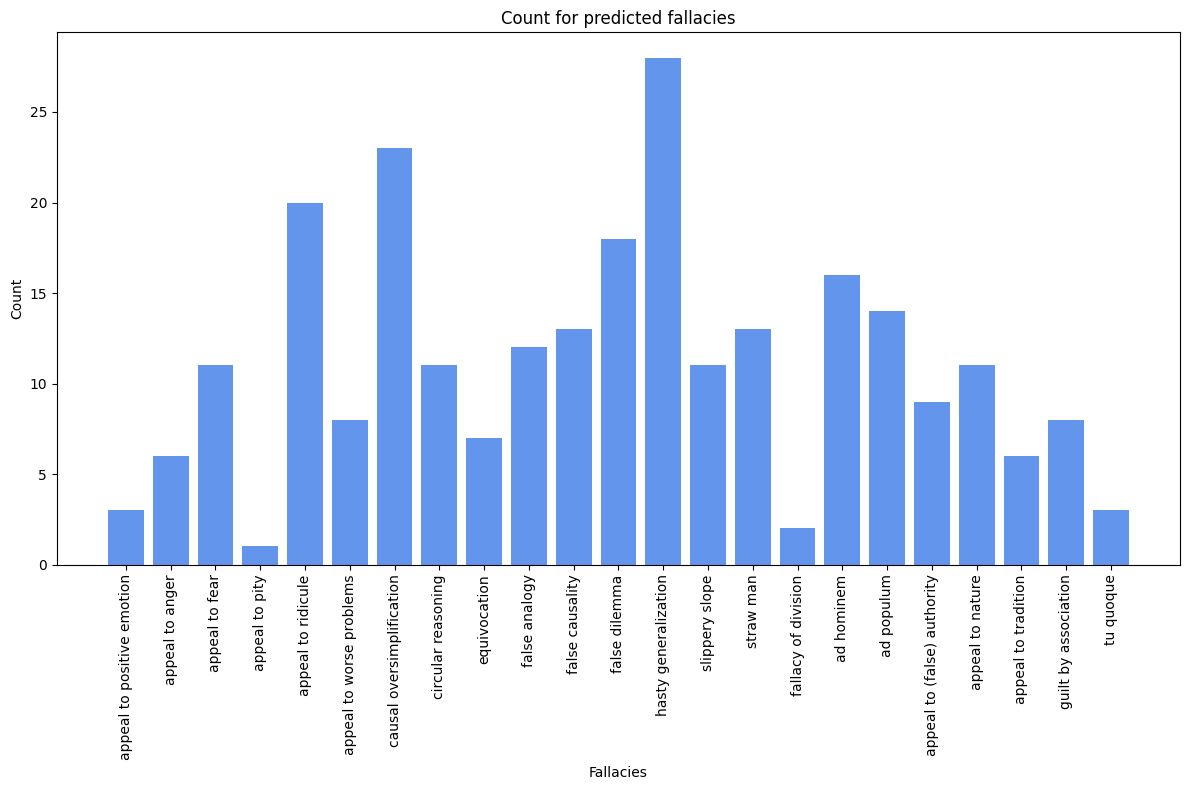

In [9]:
plot_bar_labels_count(gold_labels_count)

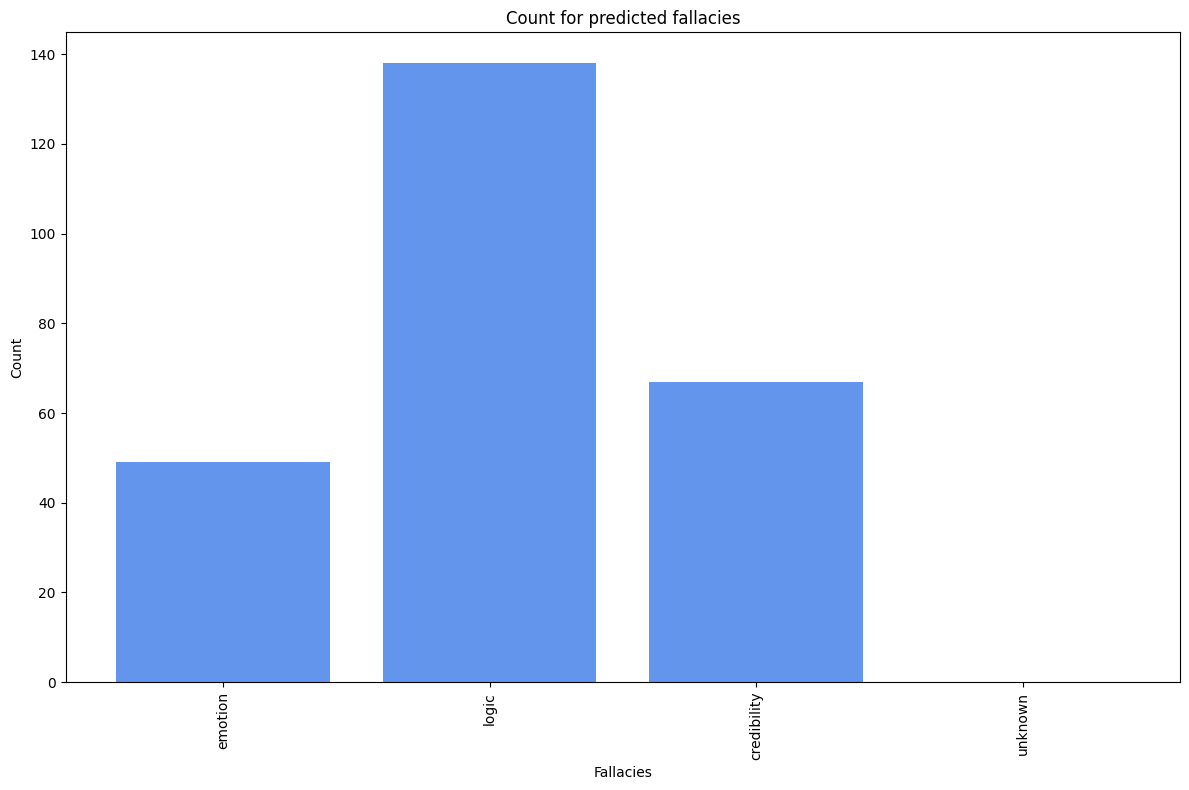

In [10]:
plot_bar_labels_count(transform_level_2_to_level_1(gold_labels_count))

#### Worst Predictions

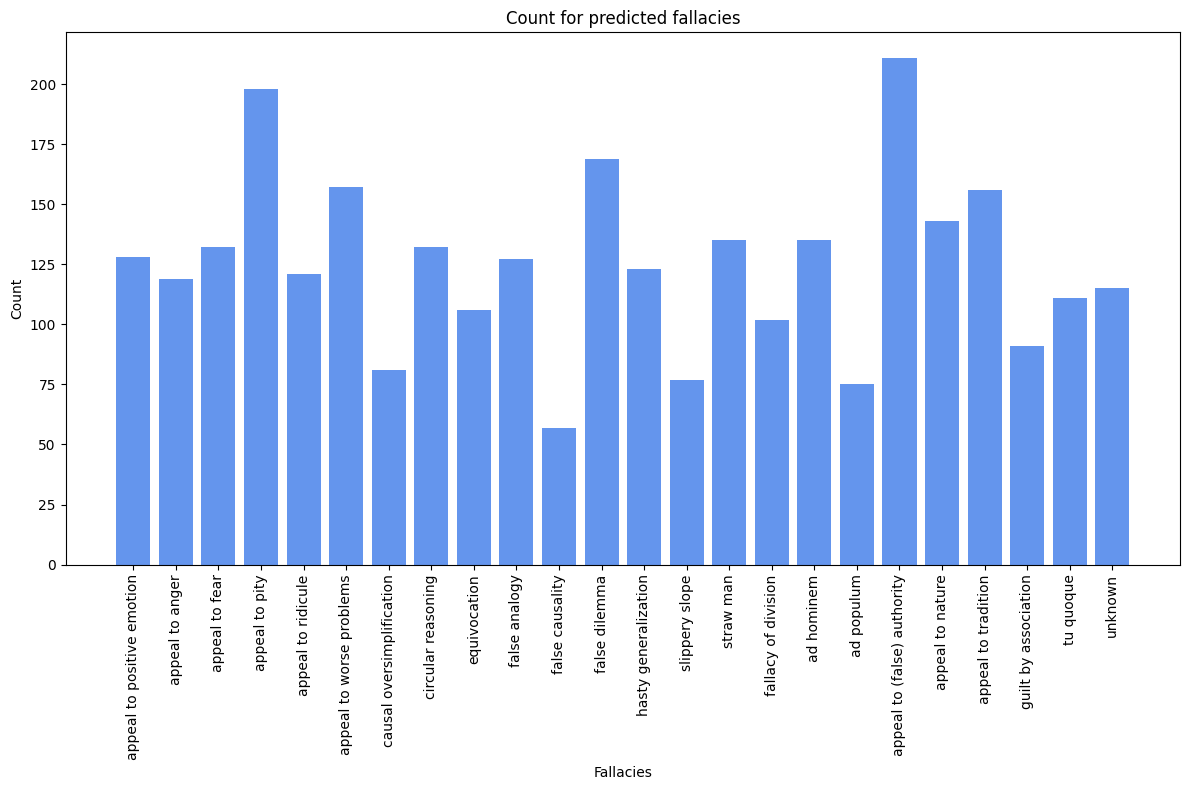

In [11]:
plot_bar_labels_count(worst_pred_labels_count)

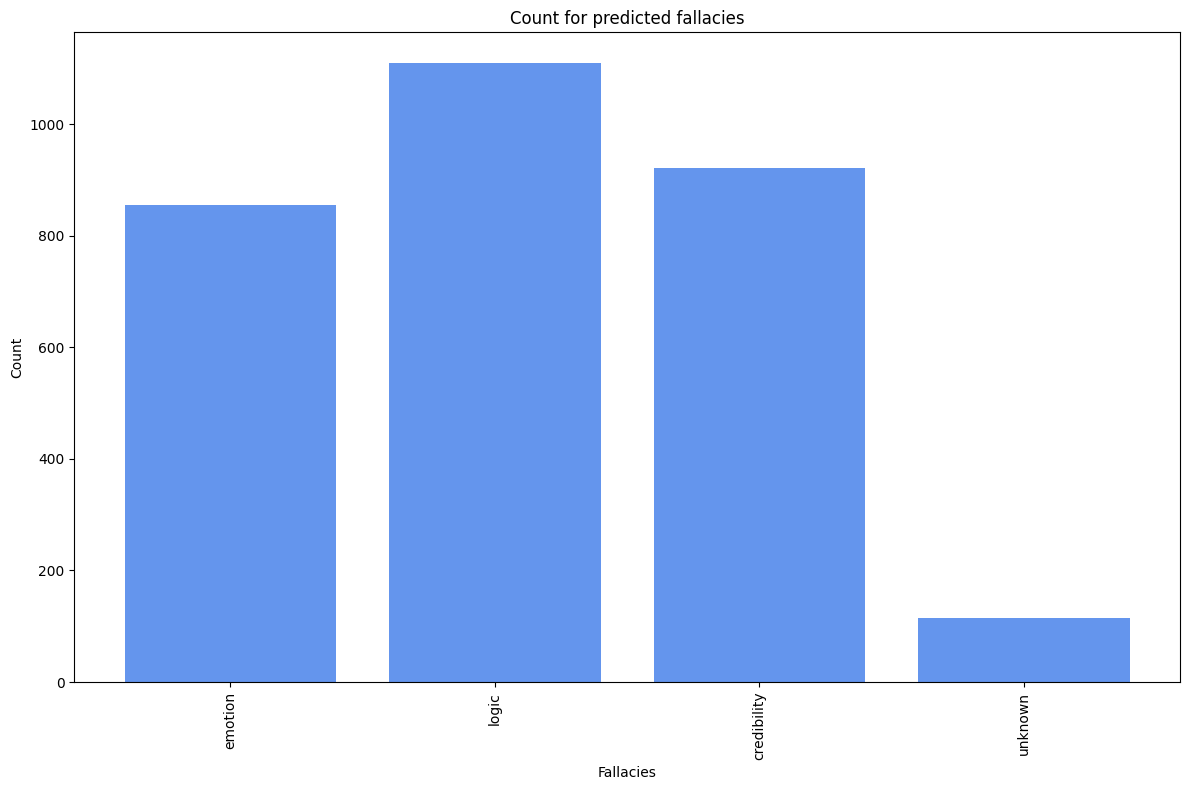

In [12]:
plot_bar_labels_count(transform_level_2_to_level_1(worst_pred_labels_count))

#### Best Predictions

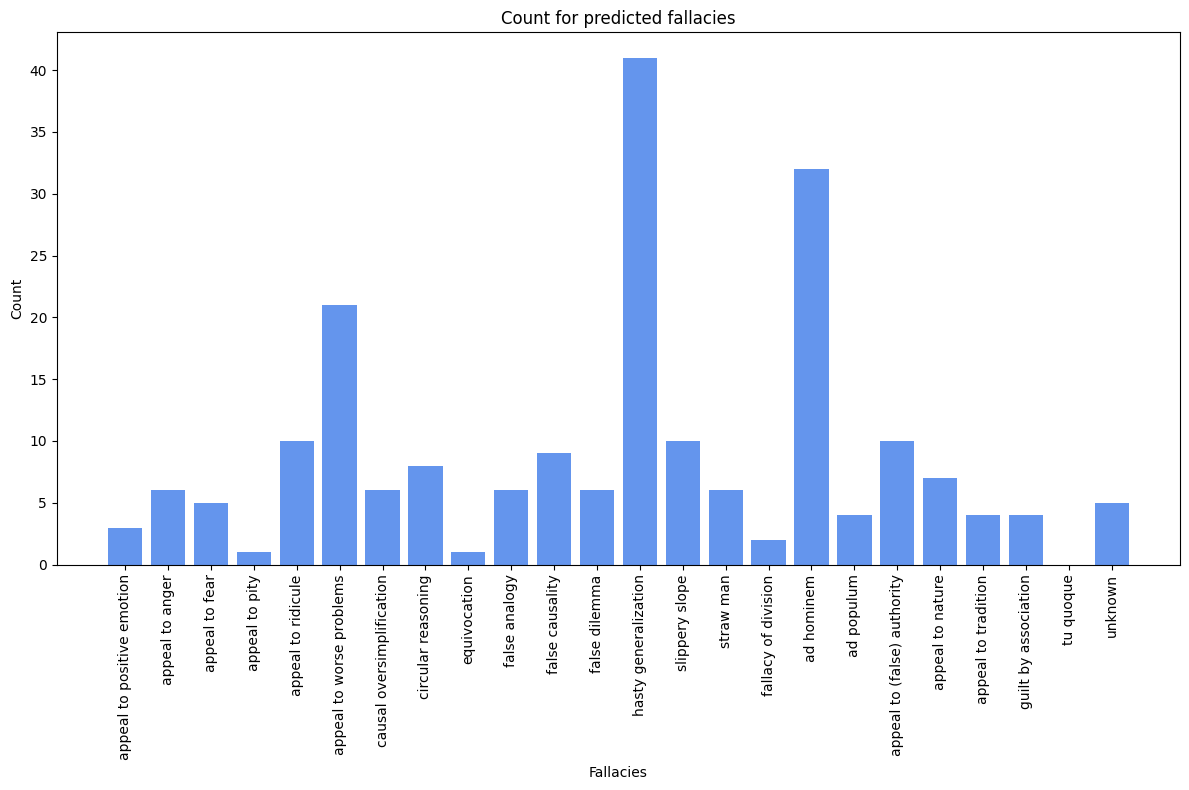

In [13]:
plot_bar_labels_count(best_pred_labels_count)

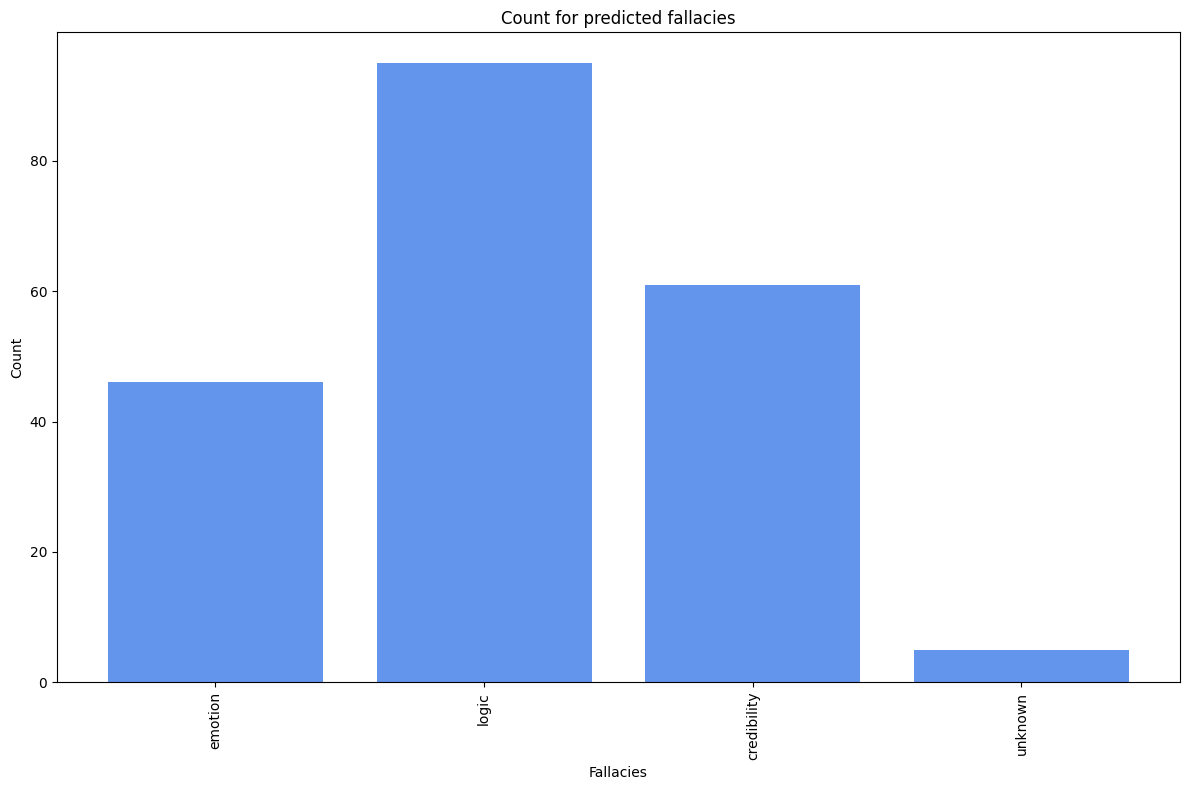

In [14]:
plot_bar_labels_count(transform_level_2_to_level_1(best_pred_labels_count))

In [15]:
print(all_dict_best_pred_spans[1])
print(all_dict_gold_spans[1])

{(0, 83): {'nothing'}, (84, 145): {'hasty generalization'}}
{(84, 145): {'hasty generalization'}, (0, 83): set()}


### Average Fallacies per Predicted Span

In [16]:
def average_fallacies_per_predicted_span(all_dict_spans):
    count_fallacies = 0
    count_span = 0
    for i in all_dict_spans:
        for span in i.keys():
            if len(i[span]) == 1 and "nothing" in i[span]:
                continue
            if "nothing" in i[span]:
                count_fallacies += len(i[span]) - 1
            else:
                count_fallacies += len(i[span])
            count_span += 1

    return count_fallacies / count_span, count_fallacies, count_span                

In [17]:
print("Average best model fallacies per fallacious span: ", average_fallacies_per_predicted_span(all_dict_best_pred_spans))
print("Average worst model fallacies per fallacious span: ", average_fallacies_per_predicted_span(all_dict_worst_pred_spans))

Average best model fallacies per fallacious span:  (1.0402010050251256, 207, 199)
Average worst model fallacies per fallacious span:  (4.8016, 3001, 625)


#### Exact Matching Fallacious Span

In [18]:
def count_match_fallacious_span(all_dict_gold_spans, all_dict_pred_spans):
    gd_labels_count = {
    "nothing": 0,
    "appeal to positive emotion": 0,
    "appeal to anger": 0,
    "appeal to fear": 0,
    "appeal to pity": 0,
    "appeal to ridicule": 0,
    "appeal to worse problems": 0,
    "causal oversimplification": 0,
    "circular reasoning": 0,
    "equivocation": 0,
    "false analogy": 0,
    "false causality": 0,
    "false dilemma": 0,
    "hasty generalization": 0,
    "slippery slope": 0,
    "straw man": 0,
    "fallacy of division": 0,
    "ad hominem": 0,
    "ad populum": 0,
    "appeal to (false) authority": 0,
    "appeal to nature": 0,
    "appeal to tradition": 0,
    "guilt by association": 0,
    "tu quoque": 0,
    "unknown": 0
    }

    pred_labels_count = deepcopy(gd_labels_count)

    count_match = 0
    count_span = 0
    for ground_truth_ex, pred_truth_ex in zip(all_dict_gold_spans, all_dict_pred_spans):
        for span in ground_truth_ex.keys():
            if (len(ground_truth_ex[span]) == 1 and ("nothing" in ground_truth_ex[span])) or len(ground_truth_ex[span]) == 0: 
                continue
            if span in pred_truth_ex.keys():
                count_match += 1
                for l in ground_truth_ex[span]:
                    if l in pred_truth_ex[span]:
                        pred_labels_count[l] += 1
                    if "nothing" not in l:
                        gd_labels_count[l] += 1
            count_span += 1

    return count_match, count_span, gd_labels_count, pred_labels_count

In [19]:
count_best_match, count_best_span, gd_best_labels_count, pred_labels_count = count_match_fallacious_span(all_dict_gold_spans, all_dict_best_pred_spans)

In [47]:
print("Average best model exact mactch fallacious span", count_best_match / count_best_span, count_best_match, count_best_span)

Average best model exact mactch fallacious span 0.32019704433497537 65 203


In [21]:
pred_labels_count

{'nothing': 0,
 'appeal to positive emotion': 0,
 'appeal to anger': 0,
 'appeal to fear': 0,
 'appeal to pity': 0,
 'appeal to ridicule': 0,
 'appeal to worse problems': 4,
 'causal oversimplification': 1,
 'circular reasoning': 4,
 'equivocation': 0,
 'false analogy': 0,
 'false causality': 0,
 'false dilemma': 0,
 'hasty generalization': 10,
 'slippery slope': 1,
 'straw man': 0,
 'fallacy of division': 0,
 'ad hominem': 6,
 'ad populum': 1,
 'appeal to (false) authority': 2,
 'appeal to nature': 1,
 'appeal to tradition': 1,
 'guilt by association': 0,
 'tu quoque': 0,
 'unknown': 0}

In [22]:
count_worst_match, count_worst_span, gd_worst_labels_count, pred_worst_labels_count = count_match_fallacious_span(all_dict_gold_spans, all_dict_worst_pred_spans)

In [46]:
print("Average worst model exact mactch fallacious span", count_worst_match / count_worst_span, count_worst_match, count_worst_span)

Average worst model exact mactch fallacious span 0.4236453201970443 86 203


In [24]:
pred_worst_labels_count

{'nothing': 0,
 'appeal to positive emotion': 0,
 'appeal to anger': 0,
 'appeal to fear': 0,
 'appeal to pity': 0,
 'appeal to ridicule': 1,
 'appeal to worse problems': 1,
 'causal oversimplification': 1,
 'circular reasoning': 1,
 'equivocation': 0,
 'false analogy': 1,
 'false causality': 1,
 'false dilemma': 1,
 'hasty generalization': 4,
 'slippery slope': 0,
 'straw man': 3,
 'fallacy of division': 0,
 'ad hominem': 1,
 'ad populum': 0,
 'appeal to (false) authority': 1,
 'appeal to nature': 1,
 'appeal to tradition': 0,
 'guilt by association': 0,
 'tu quoque': 1,
 'unknown': 0}

In [25]:
def plot_bar_labels_exact_match(gd_best_labels_count, pred_labels_count, name_bar_pred_labels):

    del gd_best_labels_count["nothing"]
    del pred_labels_count["nothing"]

    del gd_best_labels_count["unknown"]
    del pred_labels_count["unknown"]
    
    labels = list(gd_best_labels_count.keys())
    values1 = list(pred_labels_count.values())
    values2 = list(gd_best_labels_count.values())

    fig, ax = plt.subplots(figsize=(10, 8))

    bar_width = 0.35
    index = np.arange(len(labels))

    ax.bar(index - bar_width/2, values1, bar_width, label=name_bar_pred_labels, color='lightsteelblue')
    ax.bar(index + bar_width/2, values2, bar_width, label='Gold Standard', color='cornflowerblue')

    ax.set_xlabel('Fallacies')
    ax.set_title('Exact match fallacies per fallacious span')
    ax.set_xticks(index)
    ax.set_xticklabels(labels)
    plt.xticks(rotation=90) 
    ax.legend()

    plt.tight_layout()
    plt.show()



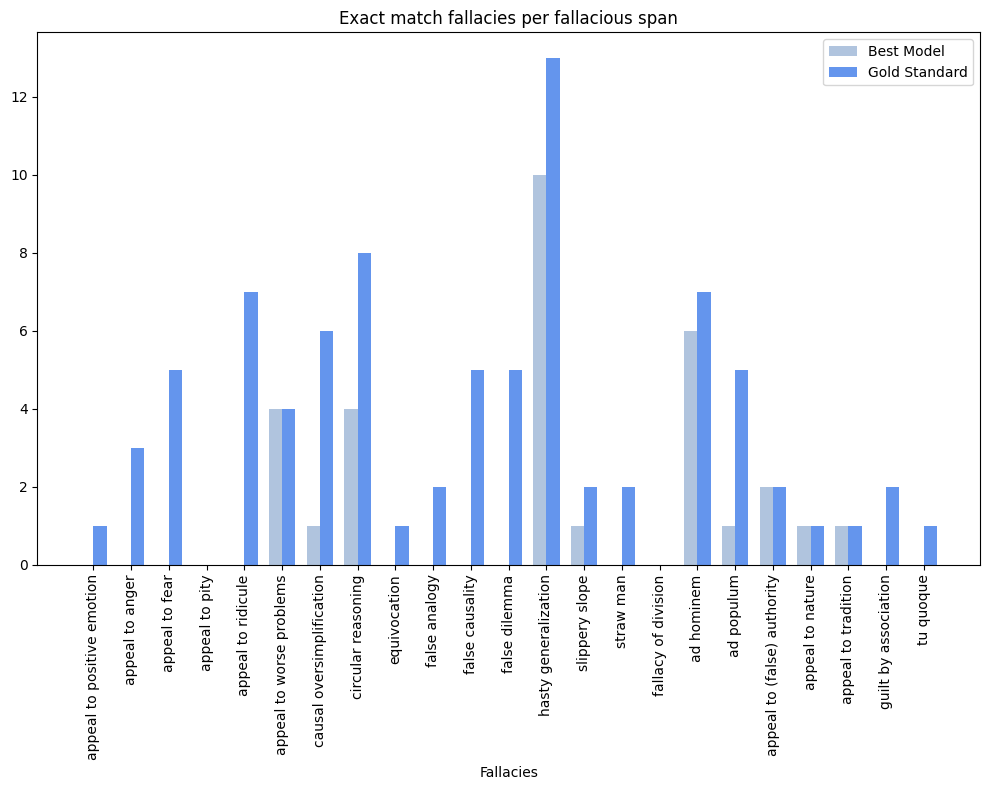

In [26]:
plot_bar_labels_exact_match(gd_best_labels_count, pred_labels_count, "Best Model")

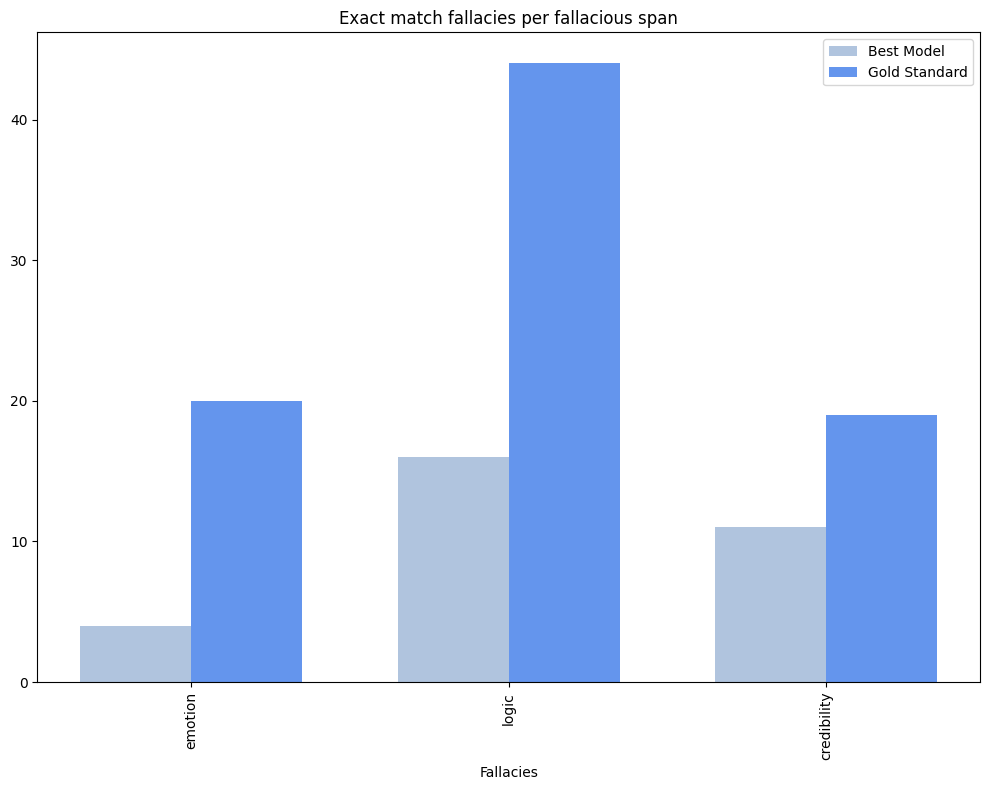

In [27]:
plot_bar_labels_exact_match(transform_level_2_to_level_1(gd_best_labels_count), transform_level_2_to_level_1(pred_labels_count), "Best Model")

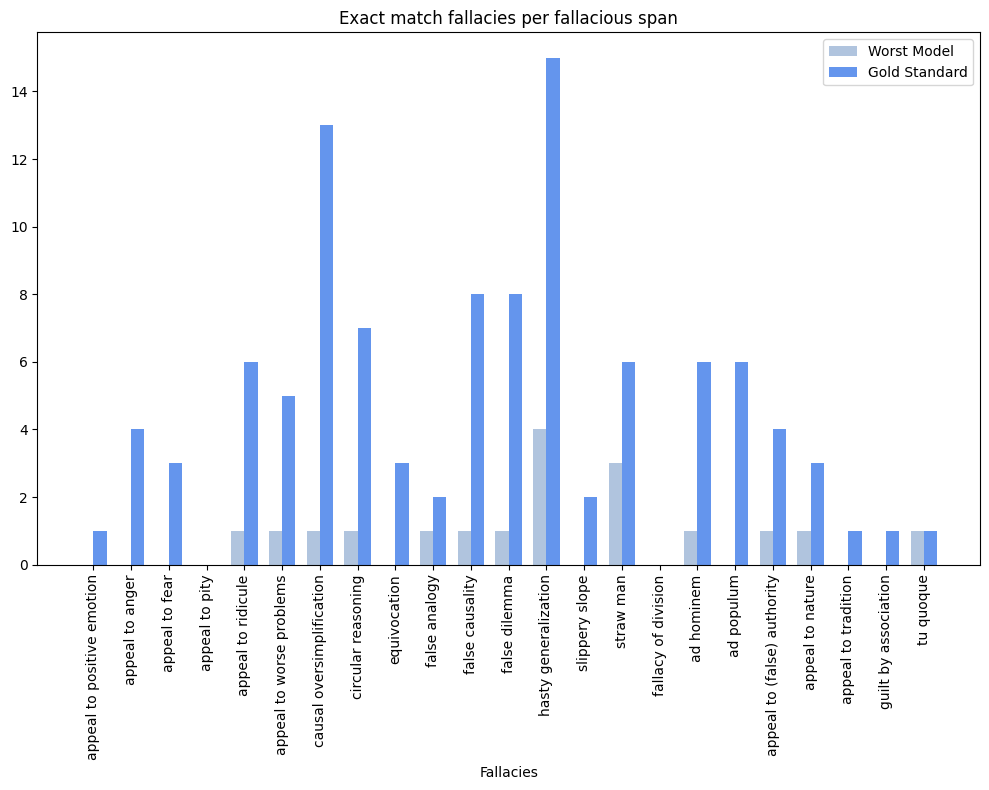

In [28]:
plot_bar_labels_exact_match(gd_worst_labels_count, pred_worst_labels_count, "Worst Model")

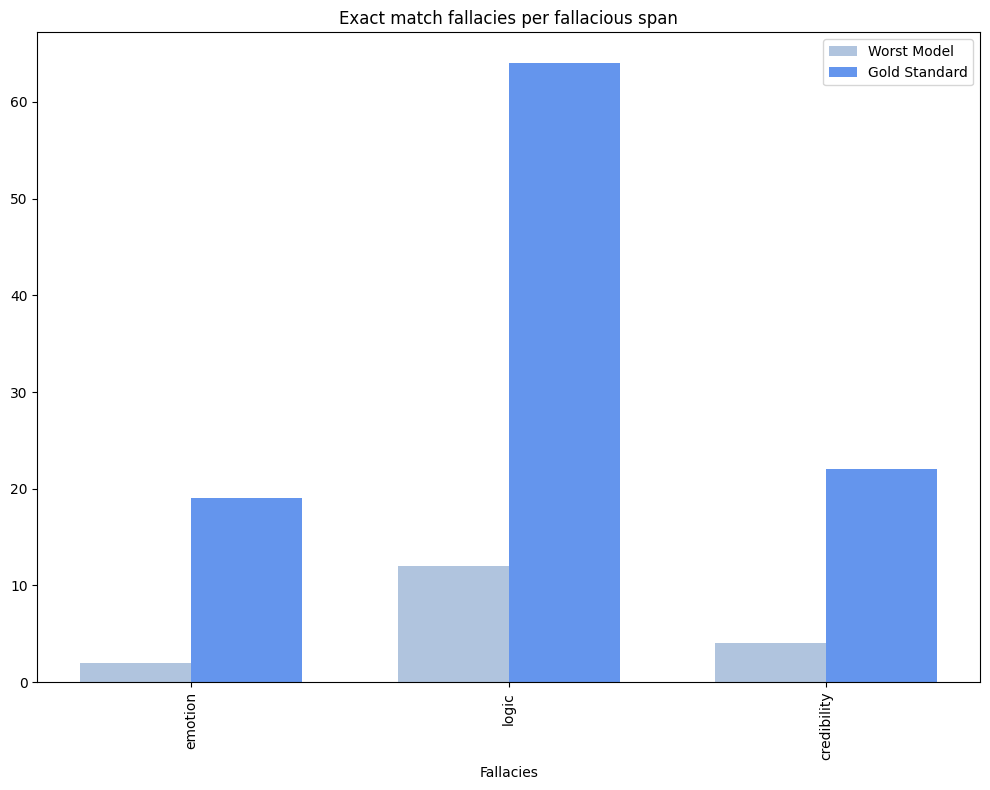

In [29]:
plot_bar_labels_exact_match(transform_level_2_to_level_1(gd_worst_labels_count), transform_level_2_to_level_1(pred_worst_labels_count), "Worst Model")

## Error Analysis of Users

In [30]:
gold_dataset = read_jsonl("datasets/user_study_examples_with_labels.jsonl")
pred_dataset_user_1 = read_jsonl("datasets/users_results/user1.jsonl")
pred_dataset_user_2 = read_jsonl("datasets/users_results/user2.jsonl")
pred_dataset_user_3 = read_jsonl("datasets/users_results/user4.jsonl")
pred_dataset_user_4 = read_jsonl("datasets/users_results/user5.jsonl")

all_y_true = []
all_y_pred_user_1 = []
all_y_pred_user_2 = []
all_y_pred_user_3 = []
all_y_pred_user_4 = []

for gold, pred_user_1, pred_user_2, pred_user_3, pred_user_4 in zip(gold_dataset, pred_dataset_user_1, pred_dataset_user_2, pred_dataset_user_3, pred_dataset_user_4):
    all_y_true.append(build_ground_truth_spans(gold["text"], gold["labels"]))
    all_y_pred_user_1.append(build_prediction_user_spans(pred_user_1["text"], pred_user_1["label"]))
    all_y_pred_user_2.append(build_prediction_user_spans(pred_user_2["text"], pred_user_2["label"]))
    all_y_pred_user_3.append(build_prediction_user_spans(pred_user_3["text"], pred_user_3["label"]))
    all_y_pred_user_4.append(build_prediction_user_spans(pred_user_4["text"], pred_user_4["label"]))


In [31]:
all_dict_gold_spans, gold_labels_count = gold_truth_per_span(all_y_true)
all_dict_best_pred_span_user_1, best_pred_labels_count_user_1 = predictions_per_span(all_y_pred_user_1)
all_dict_best_pred_span_user_2, best_pred_labels_count_user_2 = predictions_per_span(all_y_pred_user_2)
all_dict_best_pred_span_user_3, best_pred_labels_count_user_3 = predictions_per_span(all_y_pred_user_3)
all_dict_best_pred_span_user_4, best_pred_labels_count_user_4 = predictions_per_span(all_y_pred_user_4)

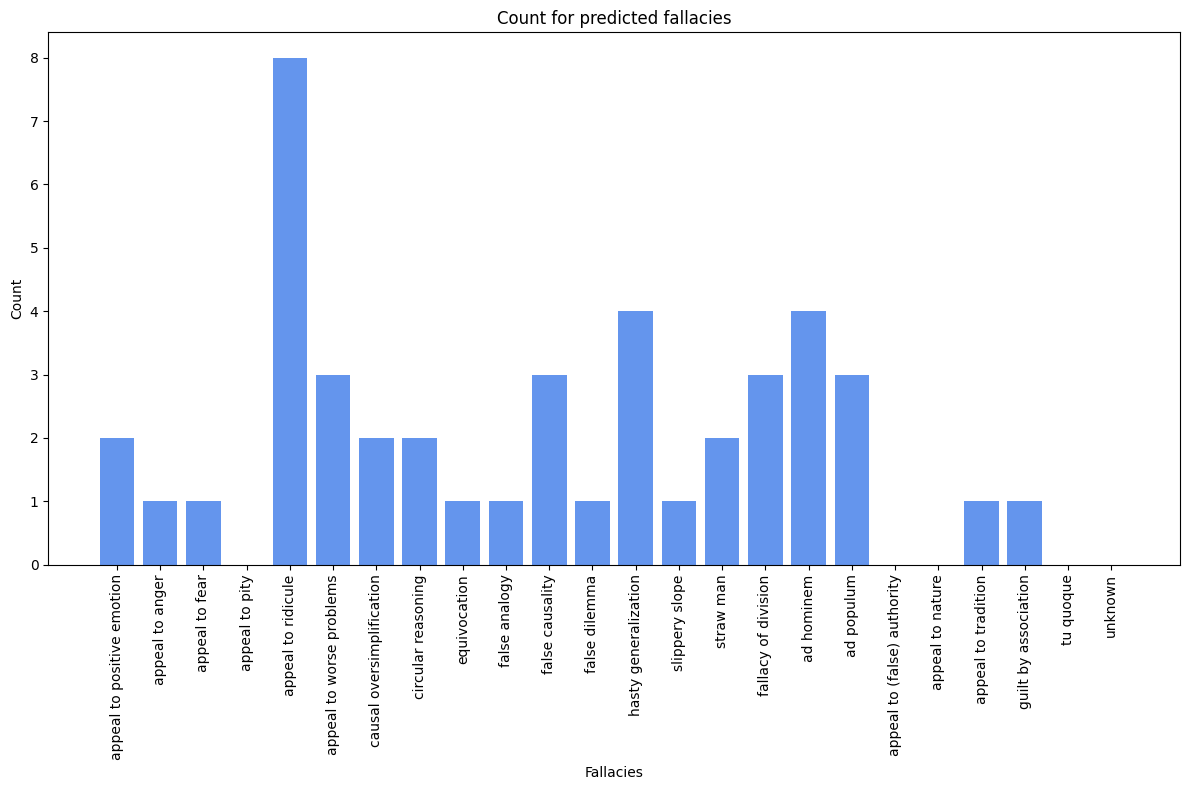

In [32]:
plot_bar_labels_count(best_pred_labels_count_user_1)

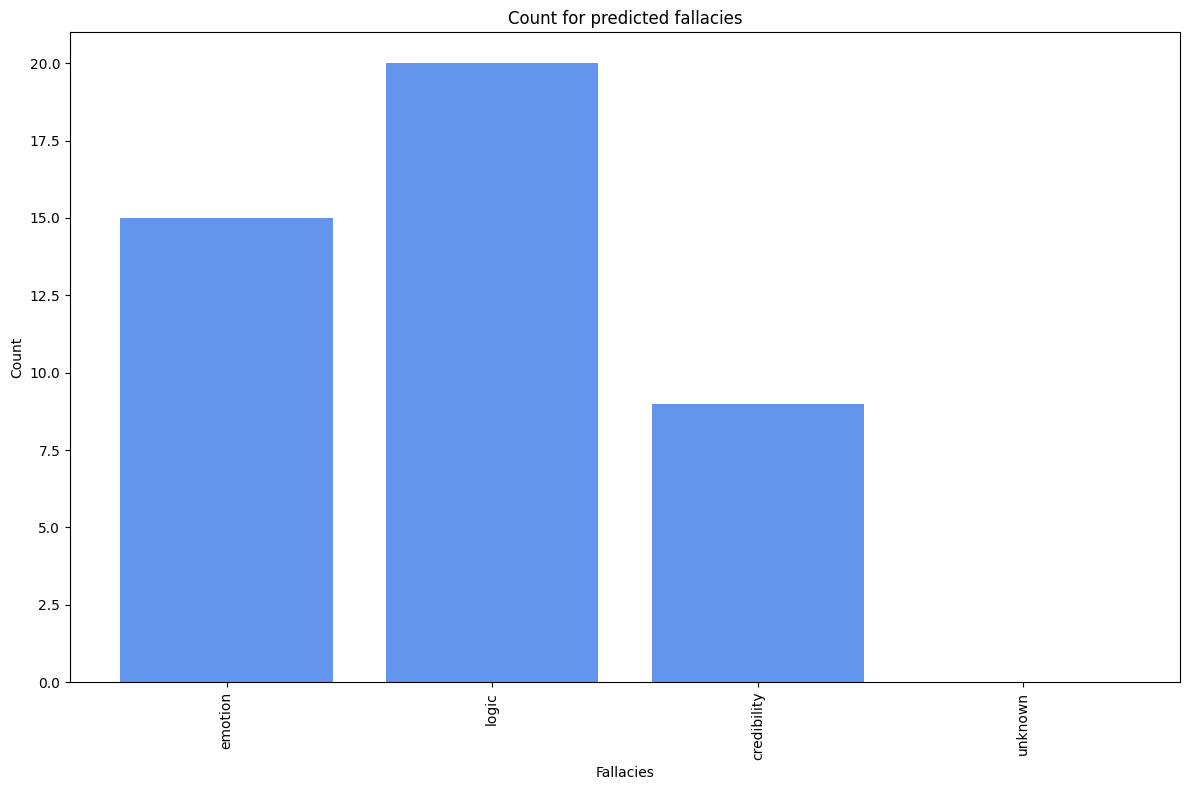

In [33]:
plot_bar_labels_count(transform_level_2_to_level_1(best_pred_labels_count_user_1))

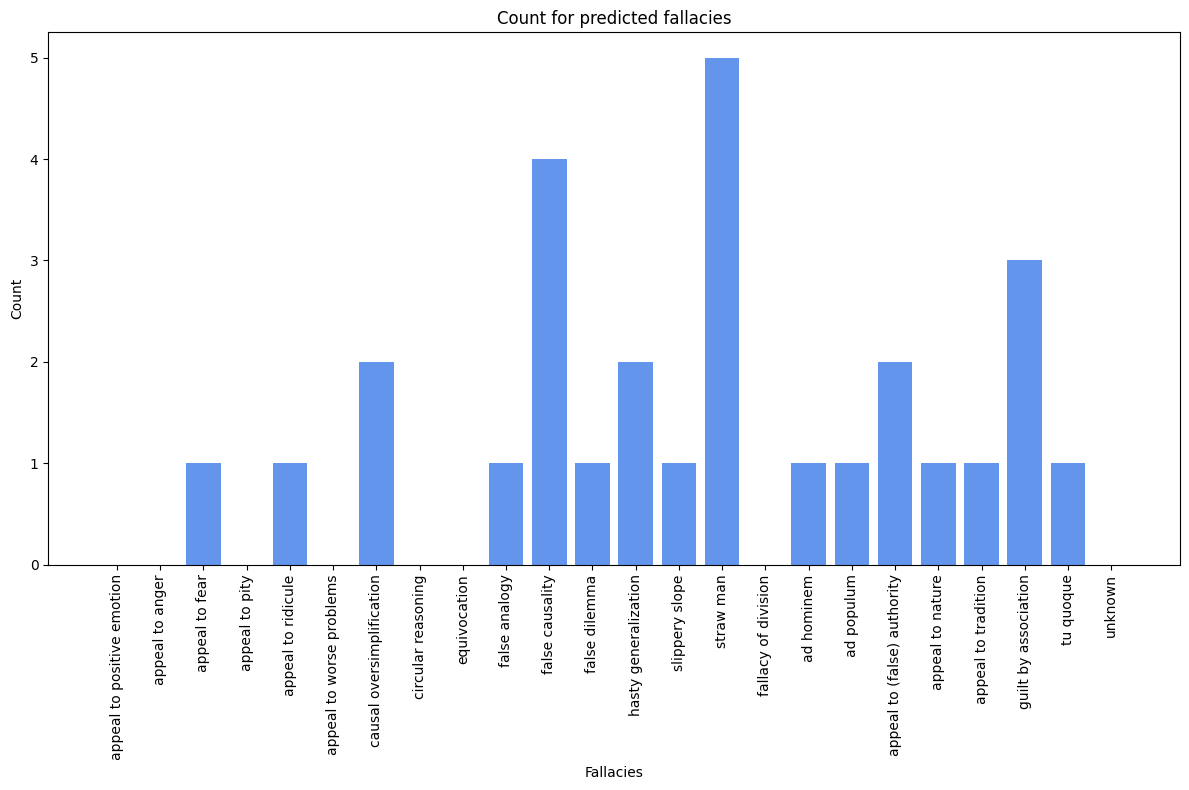

In [34]:
plot_bar_labels_count(best_pred_labels_count_user_2)

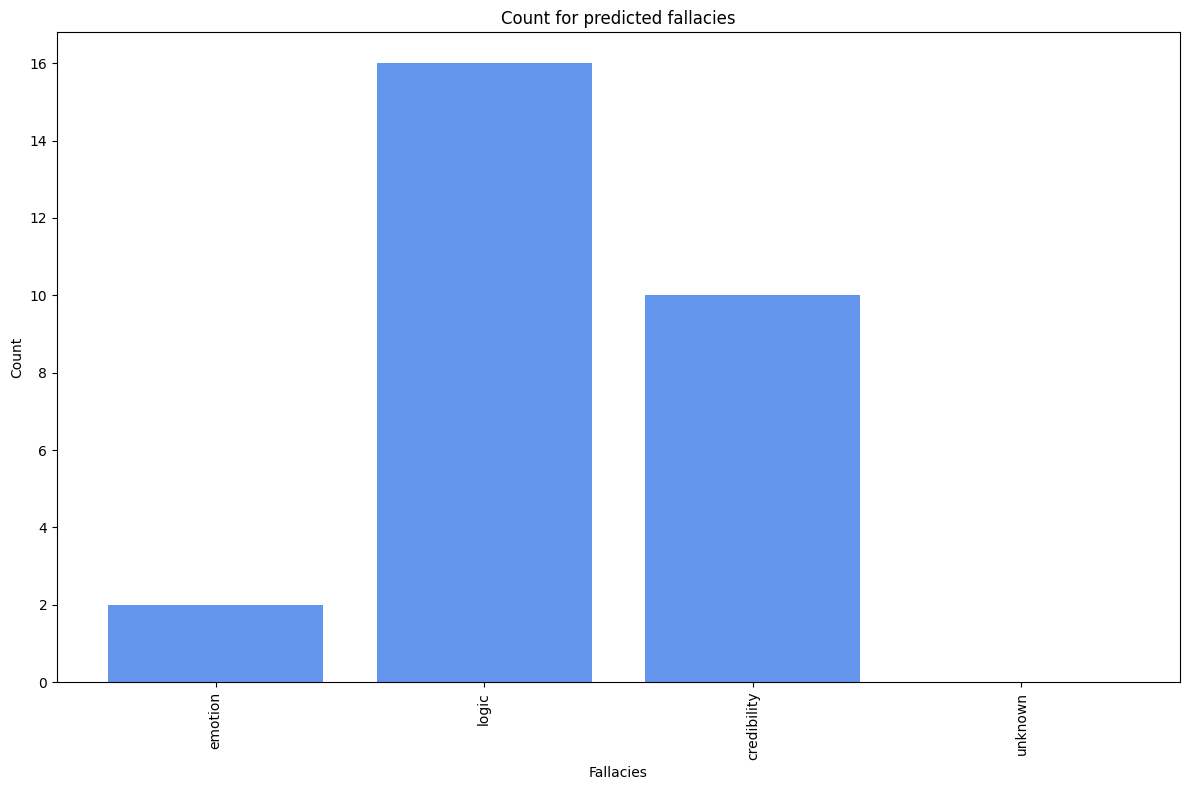

In [35]:
plot_bar_labels_count(transform_level_2_to_level_1(best_pred_labels_count_user_2)) 

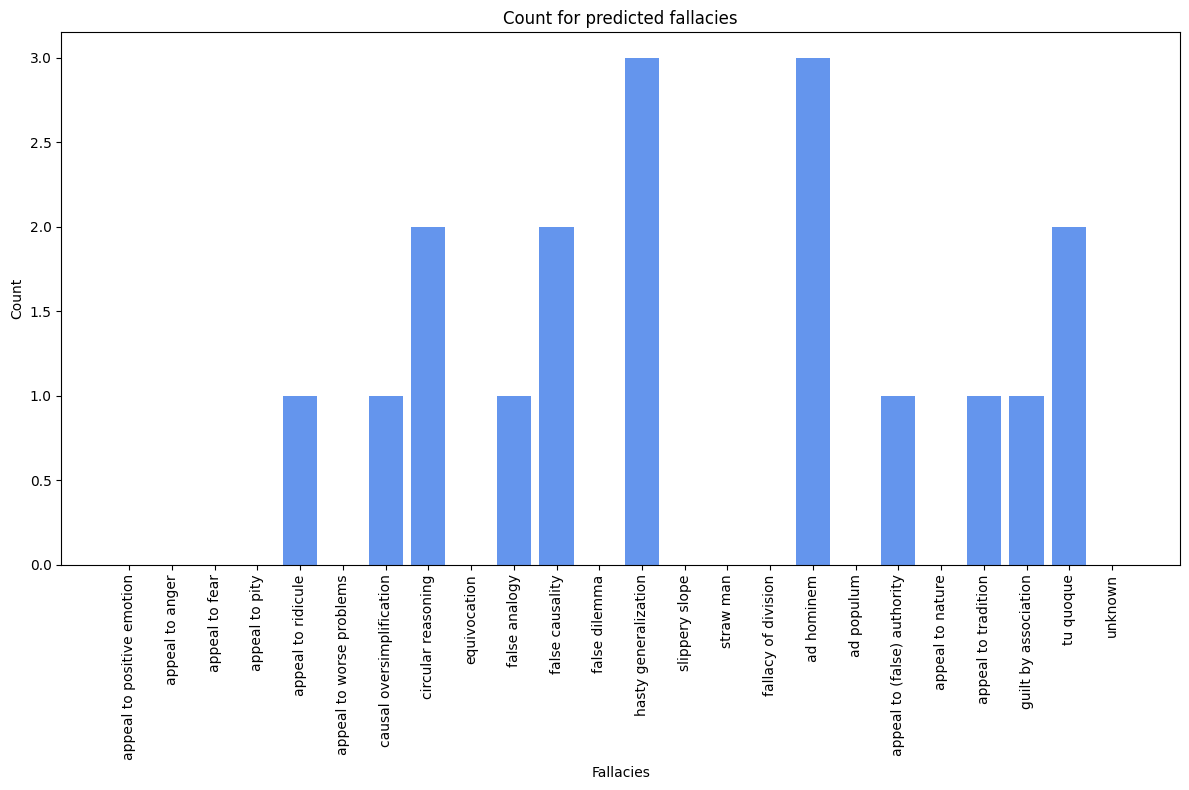

In [36]:
plot_bar_labels_count(best_pred_labels_count_user_3)

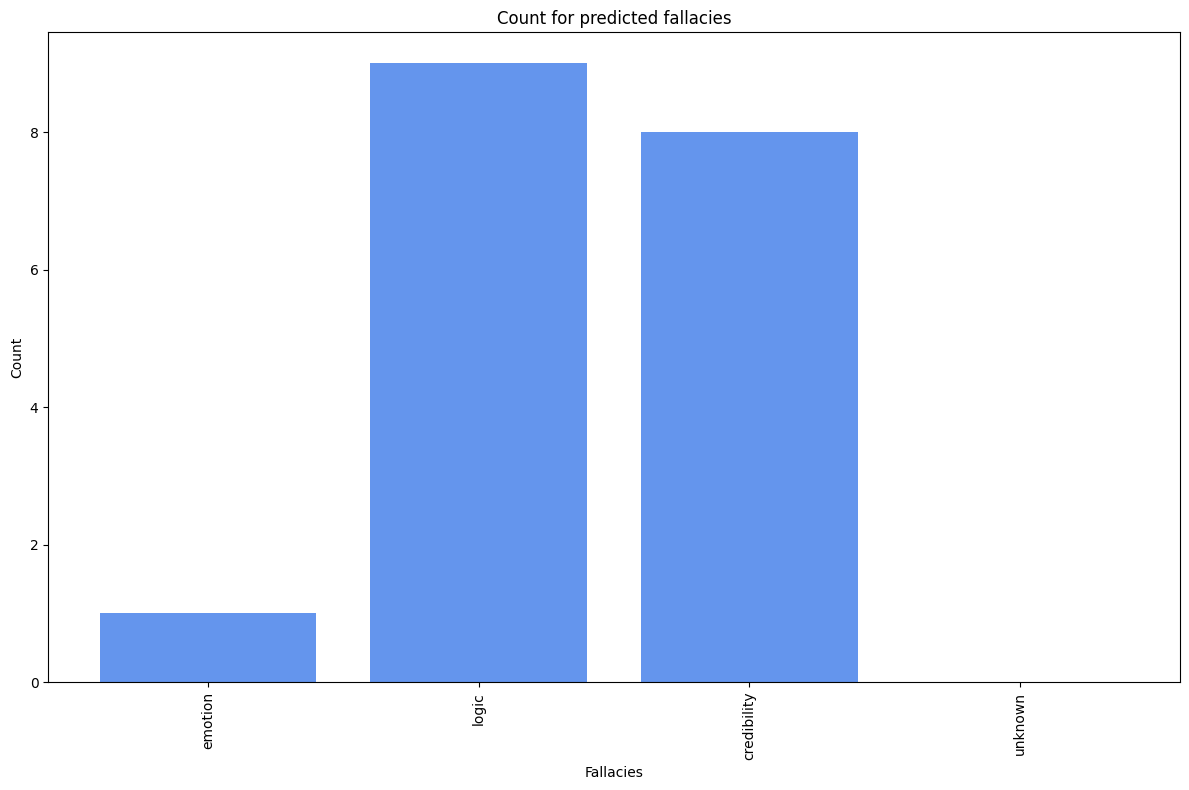

In [37]:
plot_bar_labels_count(transform_level_2_to_level_1(best_pred_labels_count_user_3))

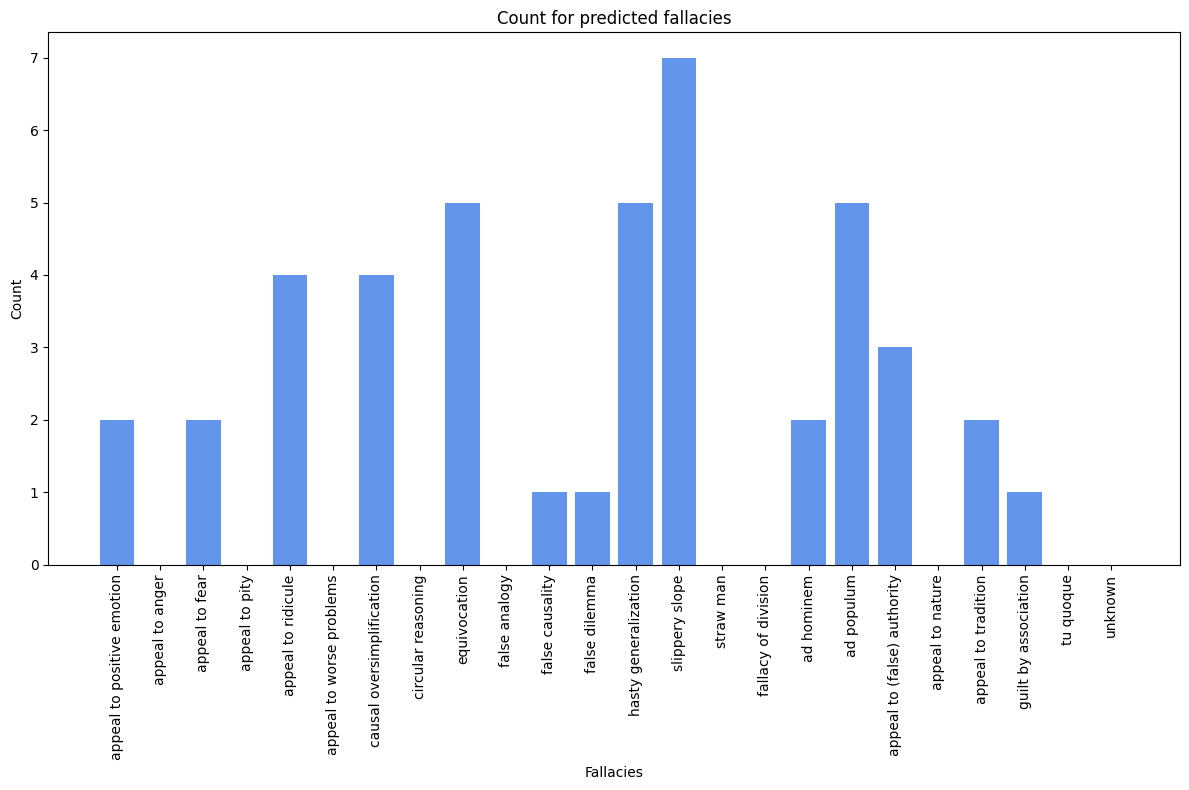

In [38]:
plot_bar_labels_count(best_pred_labels_count_user_4)

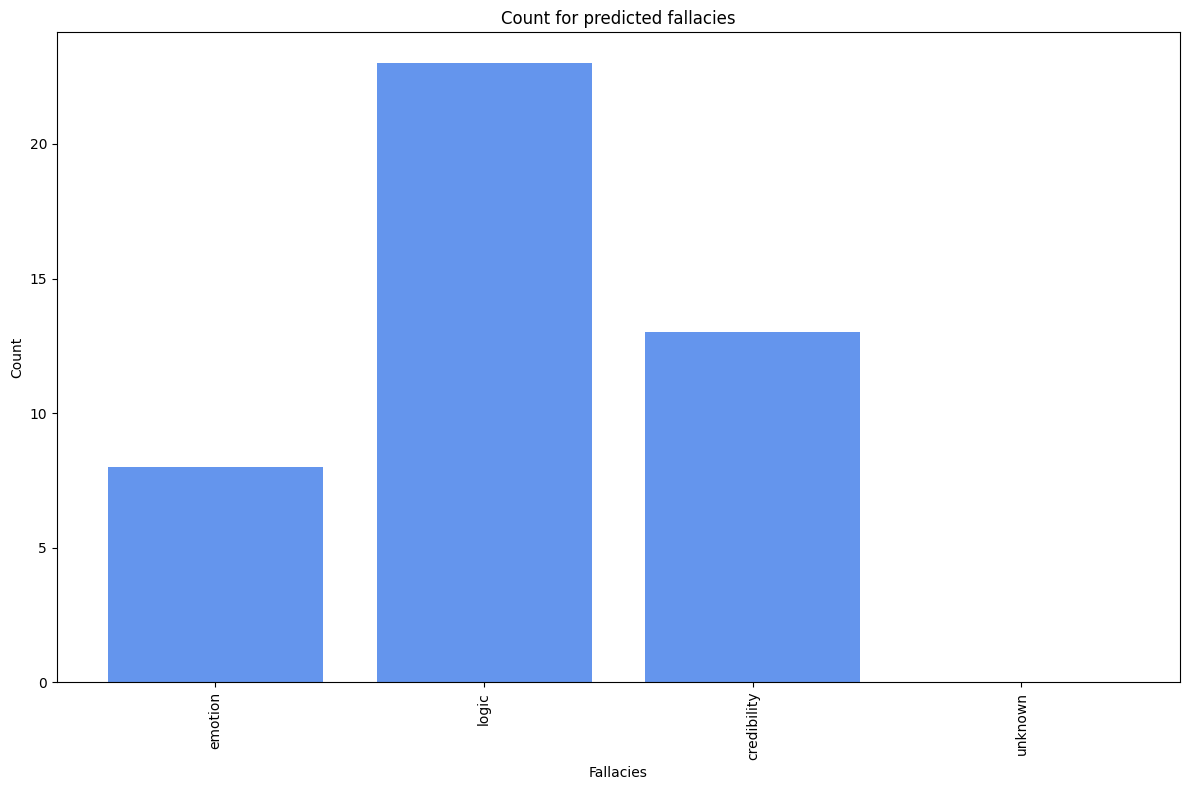

In [39]:
plot_bar_labels_count(transform_level_2_to_level_1(best_pred_labels_count_user_4))

In [40]:
count_match_user_1, count_span_user_1, gd_labels_count_user_1, pred_labels_count_user_1 = count_match_fallacious_span(all_dict_gold_spans, all_dict_best_pred_span_user_1)
count_match_user_2, count_span_user_2, gd_labels_count_user_2, pred_labels_count_user_2 = count_match_fallacious_span(all_dict_gold_spans, all_dict_best_pred_span_user_2)
count_match_user_3, count_span_user_3, gd_labels_count_user_3, pred_labels_count_user_3 = count_match_fallacious_span(all_dict_gold_spans, all_dict_best_pred_span_user_3)
count_match_user_4, count_span_user_4, gd_labels_count_user_4, pred_labels_count_user_4 = count_match_fallacious_span(all_dict_gold_spans, all_dict_best_pred_span_user_4)

In [41]:
print("Average user 1 exact mactch fallacious span", count_match_user_1 / count_span_user_1)
print("Average user 2 exact mactch fallacious span", count_match_user_2 / count_span_user_2)
print("Average user 3 exact mactch fallacious span", count_match_user_3 / count_span_user_3)
print("Average user 4 exact mactch fallacious span", count_match_user_4 / count_span_user_4)

Average user 1 exact mactch fallacious span 0.5833333333333334
Average user 2 exact mactch fallacious span 0.7916666666666666
Average user 3 exact mactch fallacious span 0.4166666666666667
Average user 4 exact mactch fallacious span 0.3333333333333333


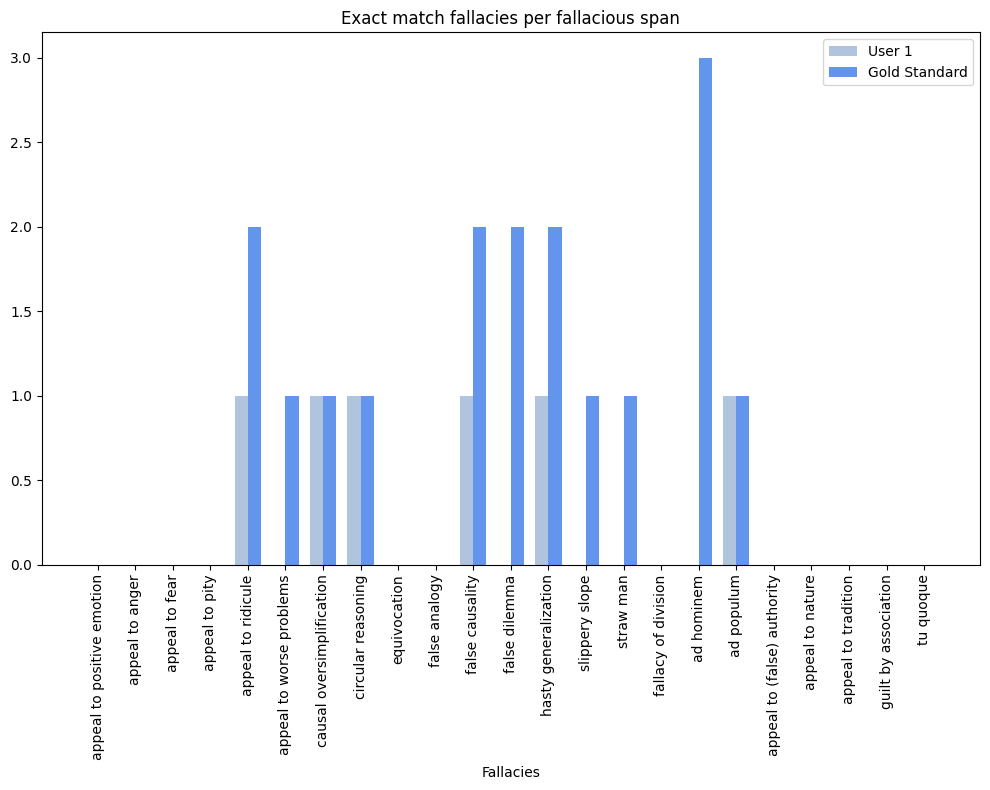

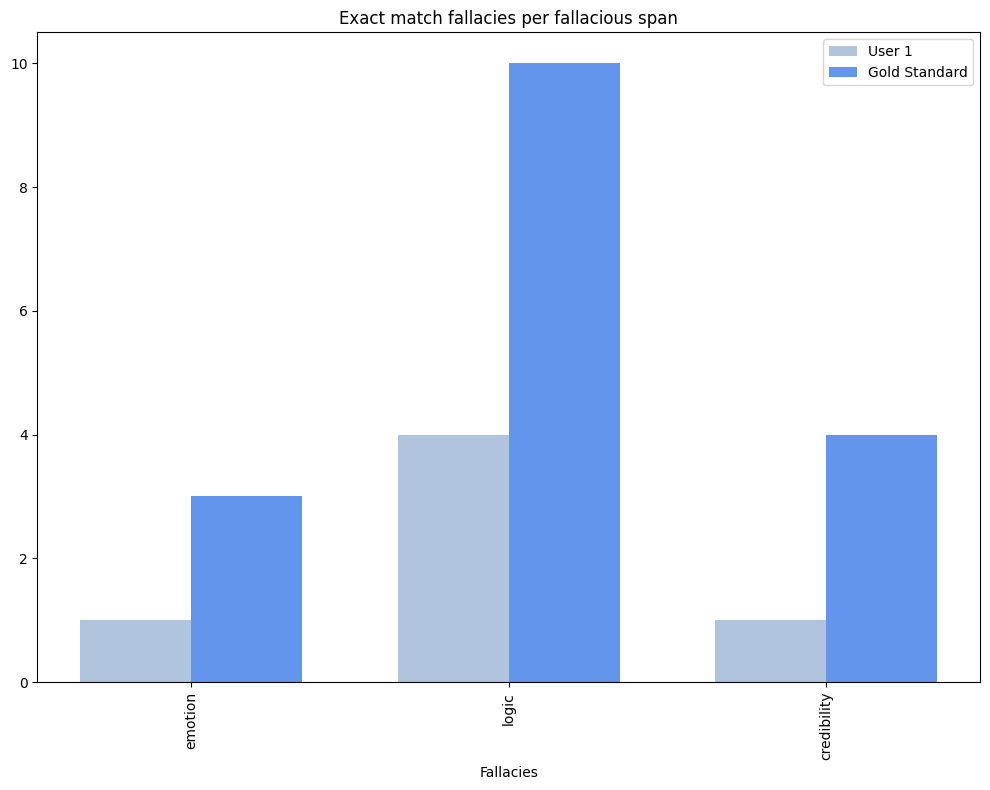

In [42]:
plot_bar_labels_exact_match(gd_labels_count_user_1, pred_labels_count_user_1, "User 1")
plot_bar_labels_exact_match(transform_level_2_to_level_1(gd_labels_count_user_1), transform_level_2_to_level_1(pred_labels_count_user_1), "User 1")

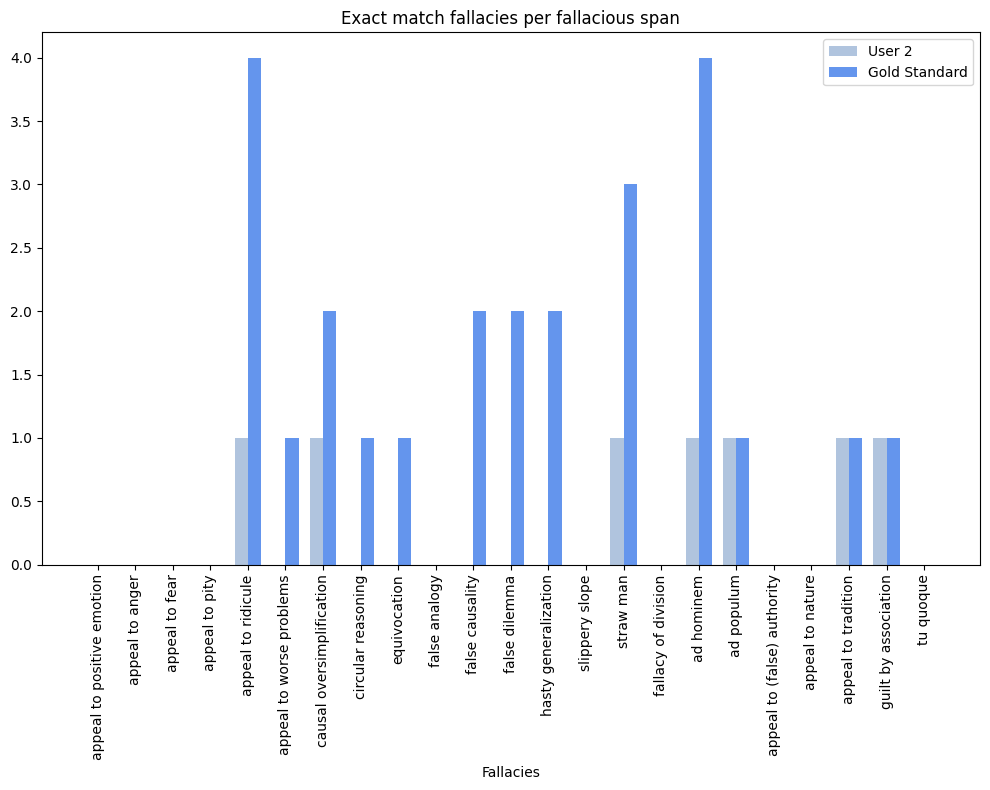

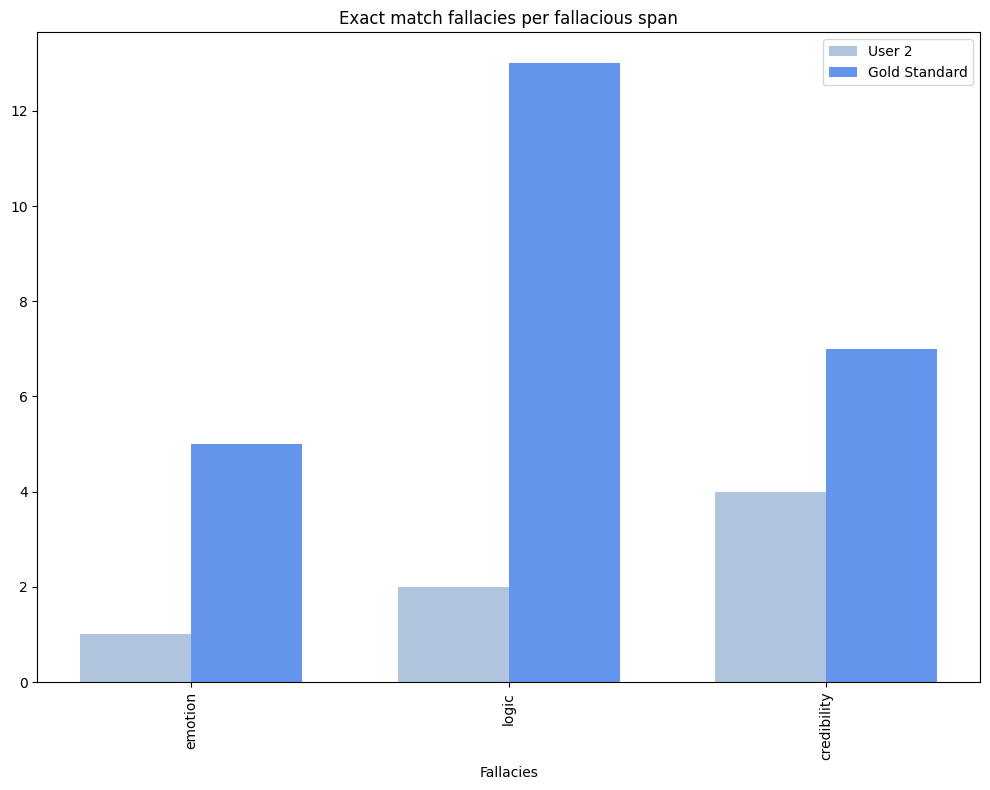

In [43]:
plot_bar_labels_exact_match(gd_labels_count_user_2, pred_labels_count_user_2, "User 2")
plot_bar_labels_exact_match(transform_level_2_to_level_1(gd_labels_count_user_2), transform_level_2_to_level_1(pred_labels_count_user_2), "User 2")

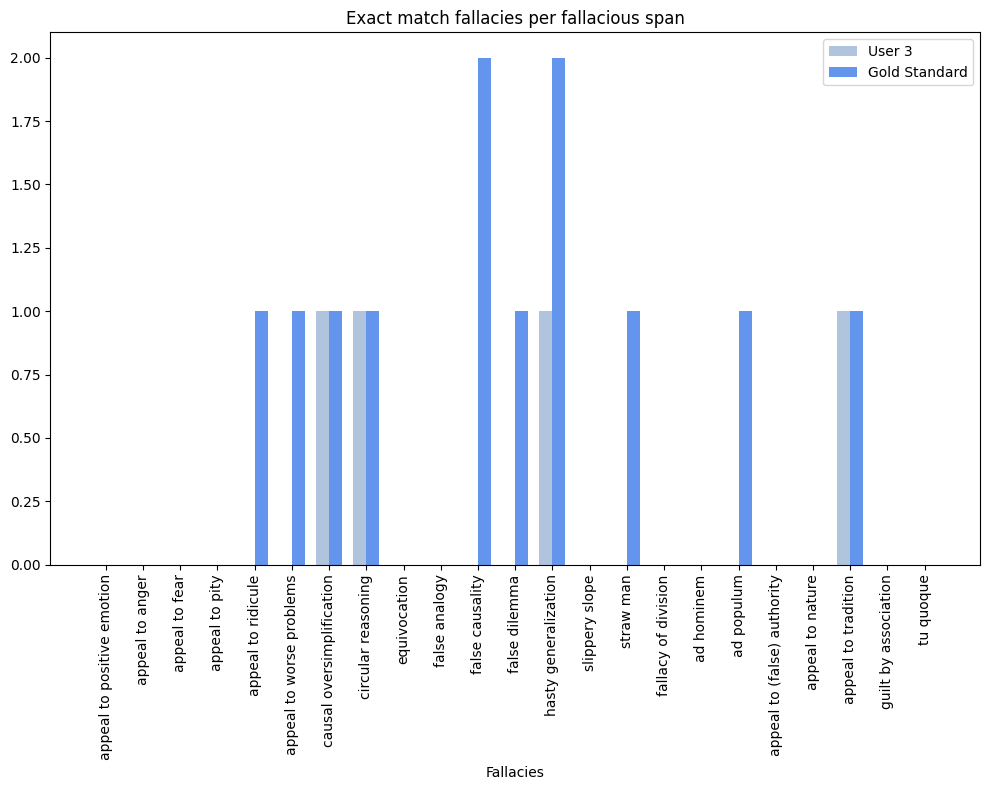

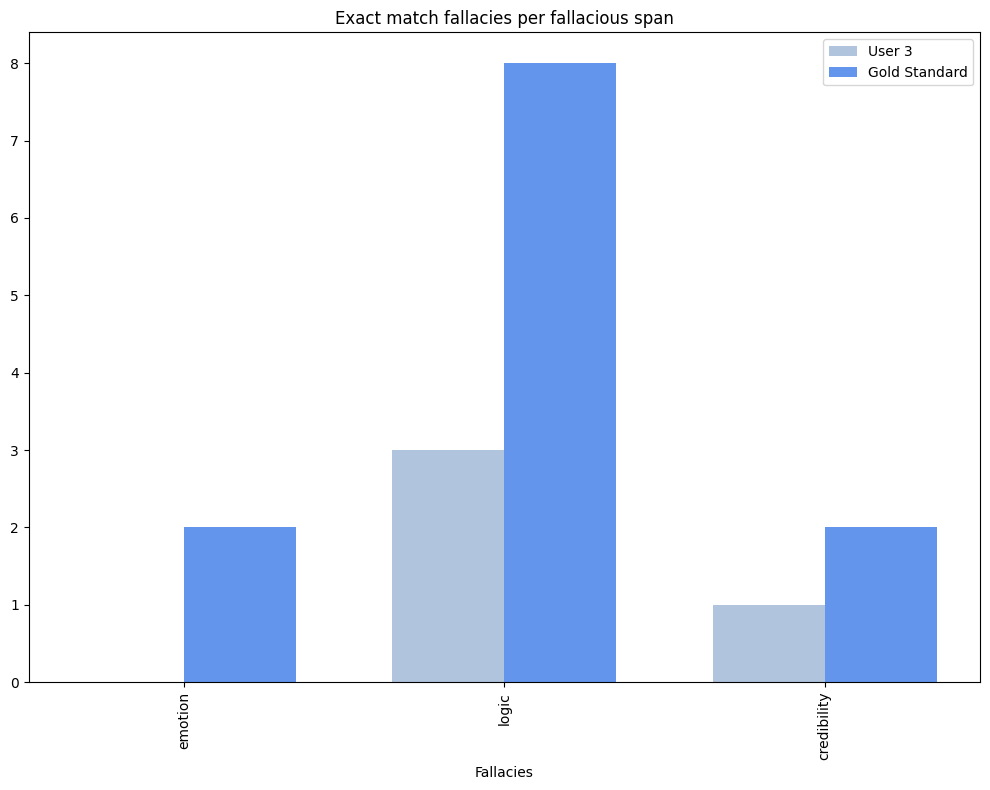

In [44]:
plot_bar_labels_exact_match(gd_labels_count_user_3, pred_labels_count_user_3, "User 3")
plot_bar_labels_exact_match(transform_level_2_to_level_1(gd_labels_count_user_3), transform_level_2_to_level_1(pred_labels_count_user_3), "User 3")

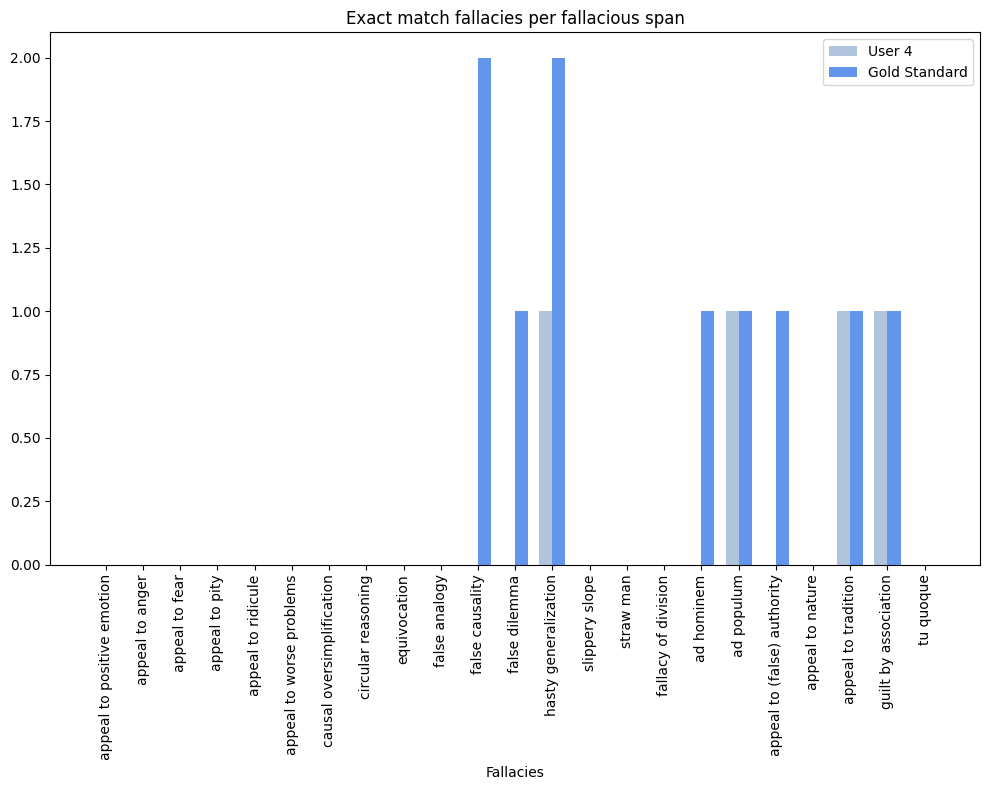

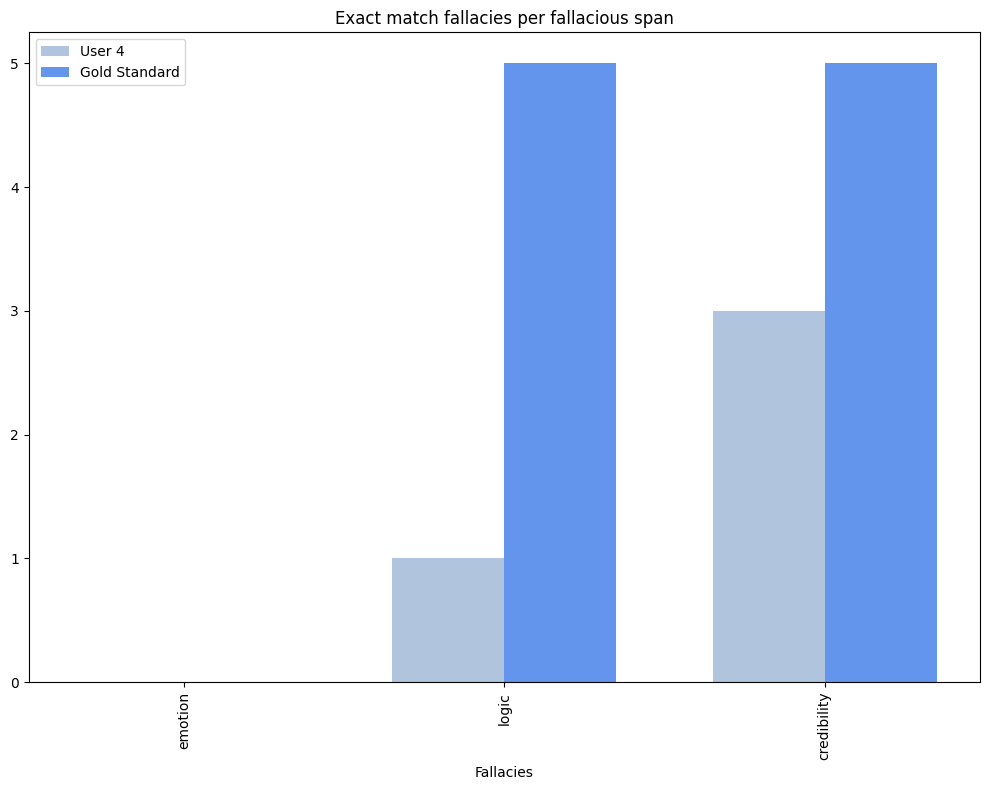

In [45]:
plot_bar_labels_exact_match(gd_labels_count_user_4, pred_labels_count_user_4, "User 4")
plot_bar_labels_exact_match(transform_level_2_to_level_1(gd_labels_count_user_4), transform_level_2_to_level_1(pred_labels_count_user_4), "User 4")